In [1]:
from turtle import distance

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist,pdist
from scipy.linalg import svd
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *
import pysindy as ps 


def solve_SVD_system(A, b):
    """
    Solve an underdetermined system Ax = b using SVD.

    Parameters:
    A (numpy.ndarray): The coefficient matrix (m x n) where m < n.
    b (numpy.ndarray): The right-hand side vector (m x 1).

    Returns:
    x (numpy.ndarray): The solution vector that minimizes ||Ax - b||2.
    """
    # Perform singular value decomposition (SVD) of A
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Calculate the pseudo-inverse of A using the SVD components
    S_pseudo = np.diag(1.0 / S)
    A_pseudo = Vt.T @ S_pseudo @ U.T

    # Solve for x using the pseudo-inverse
    x = A_pseudo @ b

    return x


In [2]:
def subsample_f(u,t,x,timesteps):
    num_points_to_sample = timesteps

    # Generate random indices
    random_rows = np.random.choice(u.shape[0], num_points_to_sample, replace=True)
    # random_columns = np.concatenate(([0,-1],np.random.choice(u.shape[1], num_points_to_sample-2, replace=False)))

    # Subsample the matrix
    subsampled_u = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    subsampled_x = x[random_rows]
    
    return subsampled_u,subsampled_x,random_rows

def build_final_condition(X,Y,K):
    x_min,x_max = np.min(X[:,0]),np.max(X[:,0])
    
    final_condition_points = np.vstack([np.linspace(x_min,x_max,100),np.ones(100)]).T
    final_condition_values = np.array([np.max([0,x-K]) for x in final_condition_points[:,0]])

    new_X = np.vstack((X,final_condition_points))
    new_Y = np.hstack((Y,final_condition_values))
    
    return new_X,new_Y

In [3]:


class multiquadratic_rbf:

    def eval_func(self,r):
        return np.sqrt(r**2 + 1)

    def eval_func_int_1d(self,r):
        return (r*self.eval_func(r))/2+ 1/2*np.log(r + self.eval_func(r))
    
    def eval_func_2_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r1**2 + r2**2 + 1)**(1.5)/6 + (r1**2 + r2**2 + r1**2 + 1)/2*r1*np.log(r1 + np.sqrt(r1**2 + r2**2 + 1))
    
    def eval_func_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return r1*np.sqrt(r1**2 + r2**2 + 1)/2 + (r2**2 +1)/2*np.log(r1 + np.sqrt(r1**2 + r2**2 + 1))

    def eval_func_2_int_1d(self,r):
        return ((r**2) + 1)**1.5/6 + 1/2*r*np.log(r + self.eval_func(r)) - 1/2*self.eval_func(r)

    def eval_func_derivative_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return r1/np.sqrt(r1**2 + r2**2 + 1)

    def eval_func_2_derivative_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r2**2 + 1)/(r1**2 + r2**2 + 1)**(3/2)
    

class cubic_rbf:

    def eval_func(self,r):
        return r**3

    def eval_func_int_1d(self,r):
        return (r*self.eval_func(r))/2+ 1/2*np.log(r + self.eval_func(r))
    
    def eval_func_2_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return (r**2 + 1)**1.5/6 + (r**2 - (r1)**2 + 1)*r1/2*np.log(-r1+self.eval_func(r)) - (r**2 - (r2)**2 + 1)/2*self.eval_func(r)
    
    def eval_func_int_2d(self,r):
        r1 = -r[:,0]
        r2 = -r[:,1]
        return -1/8*(-r1)*(r1**2/r2**2 + 1)*np.sqrt(r1**2 + r2**2)*r2**2*(2/(r1**2/r2**2 + 1) + 3/(r1**2/r2**2 + 1)**2 + (3*r2*np.arcsinh(r1/r2))/(r1*(r1**2/r2**2 + 1)**5/2))

    def eval_func_2_int_1d(self,r):
        return ((r**2) + 1)**1.5/6 + 1/2*r*np.log(r + self.eval_func(r)) - 1/2*self.eval_func(r)

    def eval_func_derivative_2d(self,r):
        r1 = r[:,0]
        r2 = r[:,1]
        return 3*-r1*np.sqrt(r1**2 + r2**2)

    def eval_func_2_derivative_2d(self,r):
        r1 = r[:,0]
        r2 = r[:,1]
        return 3*(2*(r1)**2 + (r2)**2)/np.sqrt((r1)**2 + (r2)**2)


In [4]:
def IRBFN2_1d(X,Y,rbf_class,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    # Create a grid of points for interpolation
    x_max, y_max = np.max(X), np.max(Y)

    x_min = np.min(X)
    x_grid= np.linspace(x_min, x_max, 100)

    n = Y.shape[0]
    m = x_grid.shape[0]

    X_2d = np.hstack((X.reshape(-1,1),np.zeros((n,1))))
    dist_matrix = cdist(X_2d,X_2d)
    
    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = rbf_class.eval_func_2_int_1d(dist_matrix)
    
    #Add columns for constant C1 and C2
    constant_matrix = np.hstack((X.reshape(-1,1),np.ones(n).reshape(-1,1)))


    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = np.abs(X - x_grid[i]) + epsilon
        H_i = np.hstack((rbf_class.eval_func_2_int_1d(distances),x_grid[i],1))
        h_i = np.hstack((rbf_class.eval_func_int_1d(distances),1))
        g_i = rbf_class.eval_func(distances)
        interpolated_values[i] = np.sum(coefficients * H_i)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)

    return x_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients



In [5]:

def RBFN_2d(X,Y,rbf_class,epsilon = 1e-6,grid_points=None):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = np.meshgrid(grid_points[:,0], grid_points[:,1])
    
    m = grid_points.shape[0]
    
    dist_matrix = cdist(X,X)

    # Add epsilon to the diagonal of the distance matrix to avoid singularities
    np.fill_diagonal(dist_matrix, epsilon)

    # Compute the RBF matrix
    RBF_matrix = rbf_class.eval_func(dist_matrix)

    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(RBF_matrix, Y)
    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #interpolate original function
        g_i = rbf_class.eval_func(np.linalg.norm(distances,axis=1))
        interpolated_values[i] = np.sum(coefficients * g_i)



        #Derivatives of the interpolation
        H_i = rbf_class.eval_func_2_derivative_2d(distances)
        h_i = rbf_class.eval_func_derivative_2d(distances)
        interpolated_values_x[i] = np.sum(coefficients * h_i)
        interpolated_values_xx[i] = np.sum(coefficients * H_i)

    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx, coefficients



In [6]:

def IRBFN2_2d(X,Y,rbf_class,grid_points=None,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = grid_points[:,0], grid_points[:,1] 
    #Interpolate the integration constant under the other variable
    _,idx = np.unique(X[:,1],return_index=True)
    unique_x2 = X[:,1][idx]
    correspoding_Y = Y[idx]
    const_x2_coef = IRBFN2_1d(unique_x2,correspoding_Y,rbf_class)[-1]


    n = Y.shape[0]
    m = grid_points.shape[0]

    # Interpolate values for the grid points
    dist_matrix = np.zeros((n,n,2))
    RBF_matrix = np.zeros((n,n))
    for i in range(n):
        dist_matrix[i,:] = X - X[i]
        dist_matrix[i,i] = epsilon #Add epsilon on the diagonal elements
        # Compute the RBF matrix
        RBF_matrix[i] = rbf_class.eval_func_2_int_2d(dist_matrix[i,:])

    const_x2 =  np.hstack((np.abs(dist_matrix[:,:,1]),X[:,1].reshape(-1,1),np.ones((n,1)))) @ const_x2_coef
    constant_matrix = np.hstack(((const_x2*X[:,0]).reshape(-1,1),const_x2.reshape(-1,1)))

    full_matrix = np.hstack((RBF_matrix,constant_matrix))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #Original function
        C =  np.hstack((np.abs(distances[:,1]),grid_points[i,1],1)) @ const_x2_coef
        H_i = np.hstack((rbf_class.eval_func_2_int_2d(distances),C*grid_points[i,1],C))
        interpolated_values[i] = np.sum(coefficients * H_i)

        #Derivatives
        h_i = np.hstack((rbf_class.eval_func_int_2d(distances),C))
        g_i = rbf_class.eval_func(np.apply_along_axis(np.linalg.norm,1,distances))
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-2] * g_i)



    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients


In [7]:

def IRBFN1_2d(X,Y,rbf_class,grid_points=None,epsilon = 1e-6):
    '''
    Function for Indirect Radial basis function network
    args:
    X: set of center points
    Y: target function evaluated at X
    g: radial basis function
    h: Primitive of the rbf
    H: Primitive of h
    epsilon: staiblity control term
    '''
    if grid_points is None:
        # Create a grid of points for interpolation
        x1_max, x2_max = np.max(X[:,0]), np.max(X[:,1])

        x1_min, x2_min = np.min(X[:,0]), np.min(X[:,1])
        x1_grid, x2_grid = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
        grid_points = np.column_stack((x1_grid.ravel(), x2_grid.ravel()))
    else:
        x1_grid, x2_grid = grid_points[:,0], grid_points[:,1] 
    #Interpolate the integration constant under the other variable
    _,idx = np.unique(X[:,1],return_index=True)
    unique_x2 = X[:,1][idx]
    correspoding_Y = Y[idx]
    const_x2_coef = IRBFN2_1d(unique_x2,correspoding_Y,rbf_class)[-1]
    n = Y.shape[0]
    m = grid_points.shape[0]

    # Interpolate values for the grid points
    dist_matrix = np.zeros((n,n,2))
    RBF_matrix = np.zeros((n,n))
    for i in range(n):
        dist_matrix[i,:] = X - X[i]
        dist_matrix[i,i] = epsilon #Add epsilon on the diagonal elements
        # Compute the RBF matrix
        RBF_matrix[i] = rbf_class.eval_func_int_2d(dist_matrix[i,:])
    print(dist_matrix.shape)

    const_x2 =  np.hstack((np.abs(dist_matrix[:,:,1]),X[:,1].reshape(-1,1),np.ones((n,1)))) @ const_x2_coef
    full_matrix = np.hstack((RBF_matrix,const_x2.reshape(-1,1)))
    # Solve for the coefficients using linear equations (Ax = Y)
    coefficients = solve_SVD_system(full_matrix, Y)

    # Interpolate values for the grid points
    interpolated_values = np.zeros(m)
    # Interpolate values for the first derivative grid points
    interpolated_values_x = np.zeros(m)
    # Interpolate values for the seconde derivative grid points
    interpolated_values_xx = np.zeros(m)

    for i in range(m):
        distances = (X - grid_points[i]) + epsilon
        #Original function
        C =  np.hstack((np.abs(distances[:,1]),grid_points[i,1],1)) @ const_x2_coef
        H_i = np.hstack((rbf_class.eval_func_int_2d(distances),C))
        interpolated_values[i] = np.sum(coefficients * H_i)

        #Derivatives
        h_i = rbf_class.eval_func(np.apply_along_axis(np.linalg.norm,1,distances))
        g_i = rbf_class.eval_func_derivative_2d(distances)
        interpolated_values_x[i] = np.sum(coefficients[:-1] * h_i)
        interpolated_values_xx[i] = np.sum(coefficients[:-1] * g_i)


    return x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,coefficients


In [8]:

# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 105
T_ = 1.

timesteps = 100
spacesteps =  100

# Monte Carlo simulation
x = np.linspace(.1, K_*3, spacesteps)
t = np.linspace(0, T_, timesteps)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T
u_t = black_scholes_call_time_(X, K_, tal, r_, sigma_).T[:,:-1]
u_x = ps.FiniteDifference(axis=0,order = 7)._differentiate(u,t = x)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = x)

d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:33: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:34: RuntimeWarning: divide by zero encountered in true_divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:25: RuntimeWarning: divide by zero encountered in true_divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: divide by zero encountered in true_divide
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
d:\FACULDADE\bs-find-with-sindy\src\utils\data_utils.py:26: RuntimeWarning: invalid value encountered in multiply
  call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S *

In [9]:


subsampled_u,subsampled_x,random_rows = subsample_f(u,t,x,timesteps)

# Sample data points and values
X = np.array([list(a) for a in zip(subsampled_x,t)])

Y = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
Y_x = np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
Y_xx = np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])



In [10]:

new_X,new_Y = build_final_condition(X,Y,K_)

# Interpolate the surface
x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(X, Y,cubic_rbf())

_,_, _,interpolated_values_t,_,_ = RBFN_2d(X, Y,cubic_rbf())


x1_line = x1_grid[0,:]
x2_line = x2_grid[:,0]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RSE: 3.324974848032233e-05
RMSE: 4.057263691586405


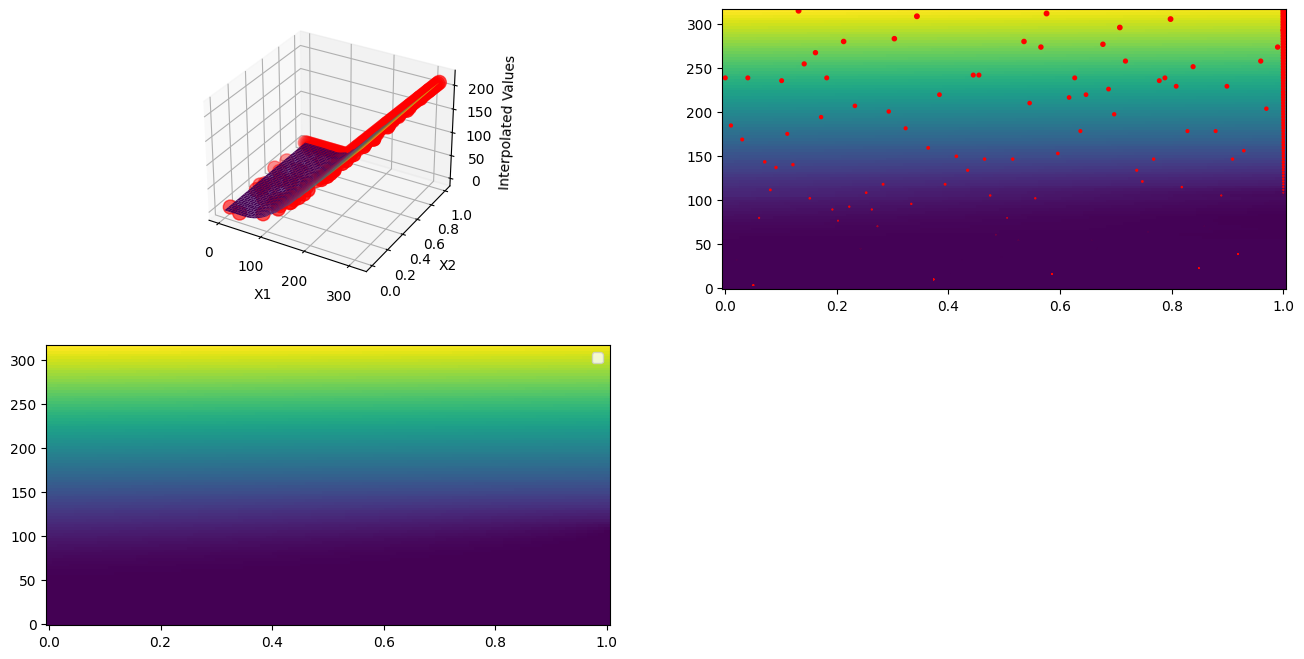

In [11]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values.reshape(x1_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(new_X[:, 0], new_X[:, 1], new_Y, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(x2_line,x1_line,  interpolated_values.reshape(x1_grid.shape).T)
ax2.scatter(new_X[:, 1], new_X[:, 0] , s=new_Y/20, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u)
ax3= plt.gca()

rse, rmse = calc_error_2d(interpolated_values.reshape(x1_grid.shape).T,u,show=True)

plt.legend()
plt.show()

c:\Anaconda3\envs\pysindy\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for numerical derivation
RSE: 0.04741486611544432
RMSE: 0.9224240629361415
Error for anayltical derivation
RSE: 0.039022189364137795
RMSE: 0.8323747196510101


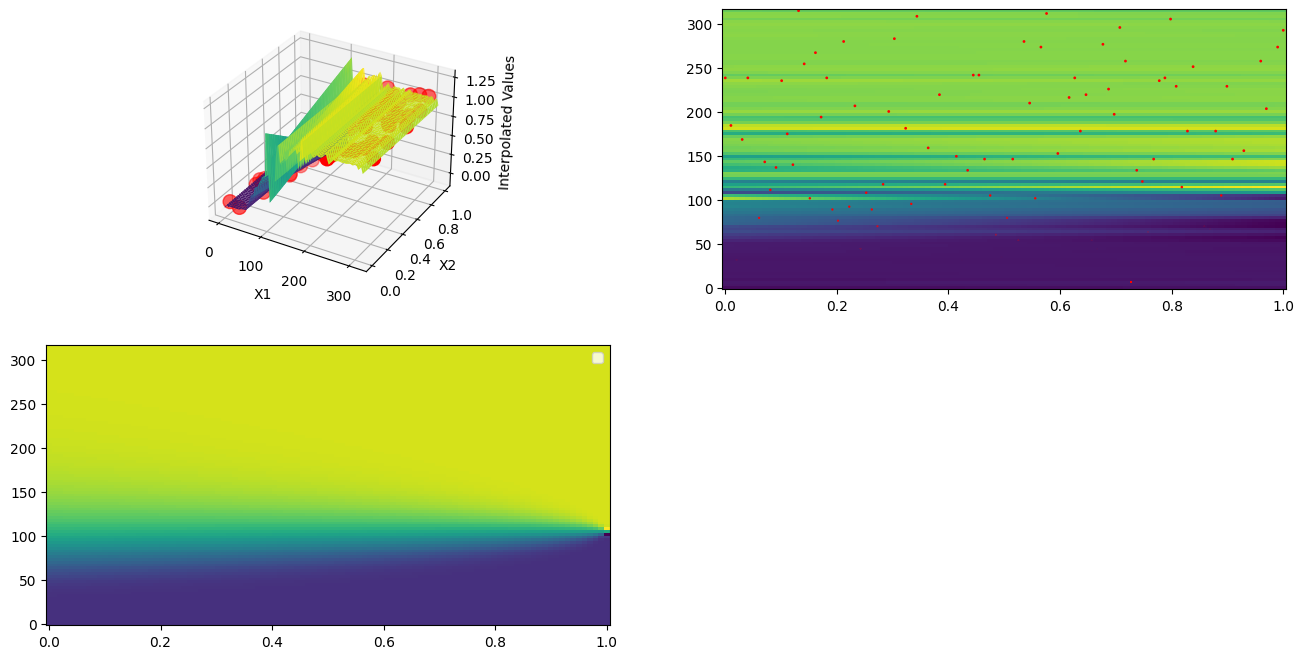

In [12]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values_x.reshape(x1_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y_x, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(222)
ax2.pcolormesh(x2_line,x1_line,  interpolated_values_x.reshape(x1_grid.shape).T)
ax2.scatter(X[:, 1],X[:, 0] , s=Y_x/1, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u_x)
ax3= plt.gca()


numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 7)._differentiate(interpolated_values,t = np.ravel(x1_grid))
print('Error for numerical derivation')
rse, rmse = calc_error_2d(numerical_derivative_interpolated.reshape(x1_grid.shape).T,u_x,show=True)
print('Error for anayltical derivation')
rse, rmse = calc_error_2d(interpolated_values_x.reshape(x1_grid.shape).T,u_x,show=True)

plt.legend()
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for numerical derivation
RSE: 0.9855584320731051
RMSE: 0.49915538173893964
Error for anayltical derivation
RSE: 1.2835786783313627
RMSE: 8.548633396156832


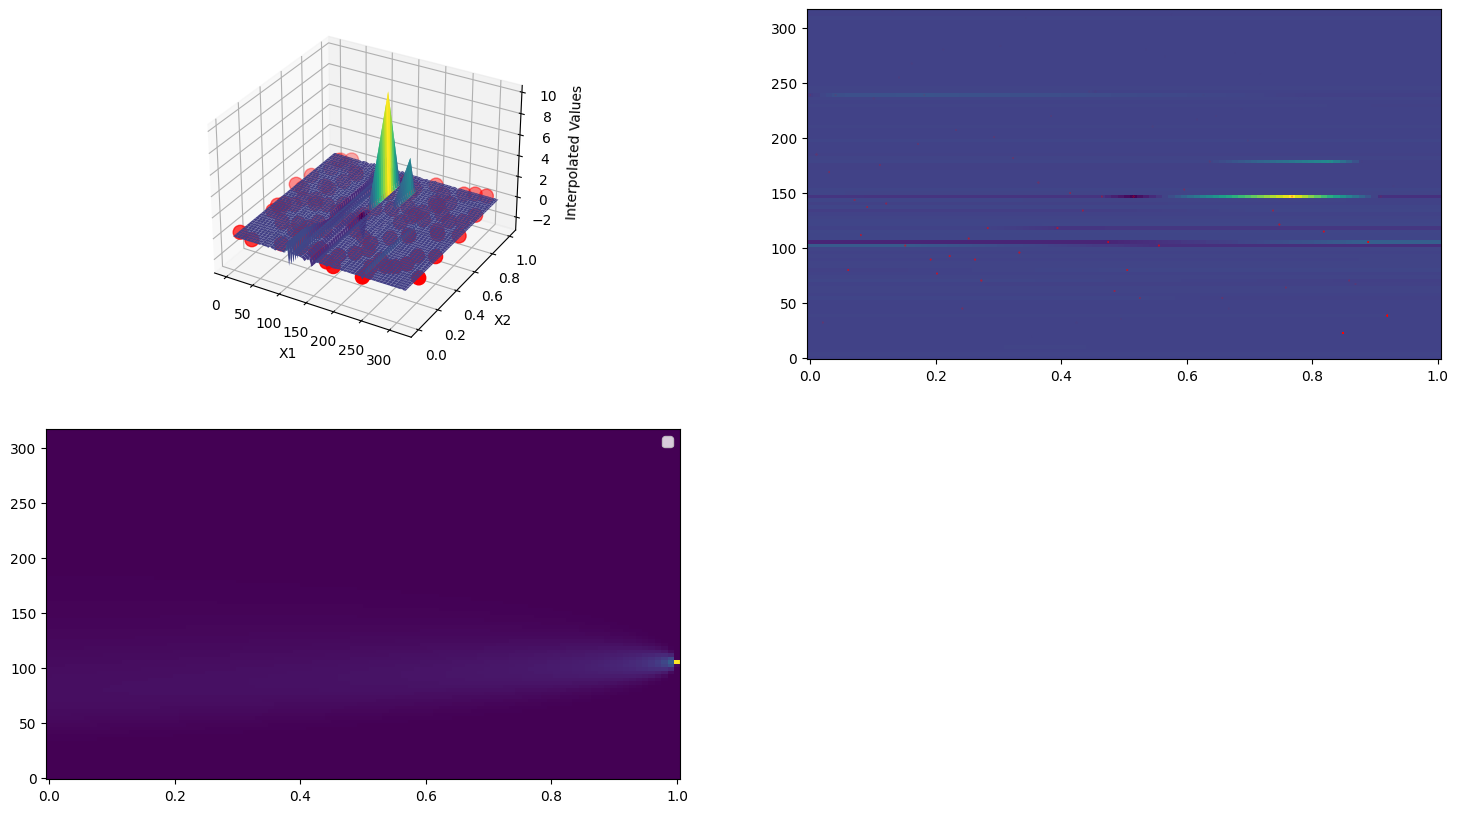

In [13]:
# Plot the interpolated surface
fig = plt.figure(figsize=[18,10])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(x1_grid, x2_grid, interpolated_values_xx.reshape(x2_grid.shape), cmap='viridis')

# Plot the original data points
ax.scatter(X[:, 0], X[:, 1], Y_xx, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(x2_line,x1_line,  interpolated_values_xx.reshape(x1_grid.shape).T)
ax2.scatter(X[:, 1],X[:, 0] , s=Y_xx*10, c='red', label='Original Data')
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(t, x, u_xx)
ax3= plt.gca()

numerical_2nd_derivative_interpolated = ps.FiniteDifference(axis=0,order = 7,d=2)._differentiate(interpolated_values,t = np.ravel(x1_grid))
print('Error for numerical derivation')
rse, rmse = calc_error_2d(numerical_2nd_derivative_interpolated.reshape(x1_grid.shape).T,u_xx,show=True)
print('Error for anayltical derivation')
rse, rmse = calc_error_2d(interpolated_values_xx.reshape(x1_grid.shape).T,u_x,show=True)


plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


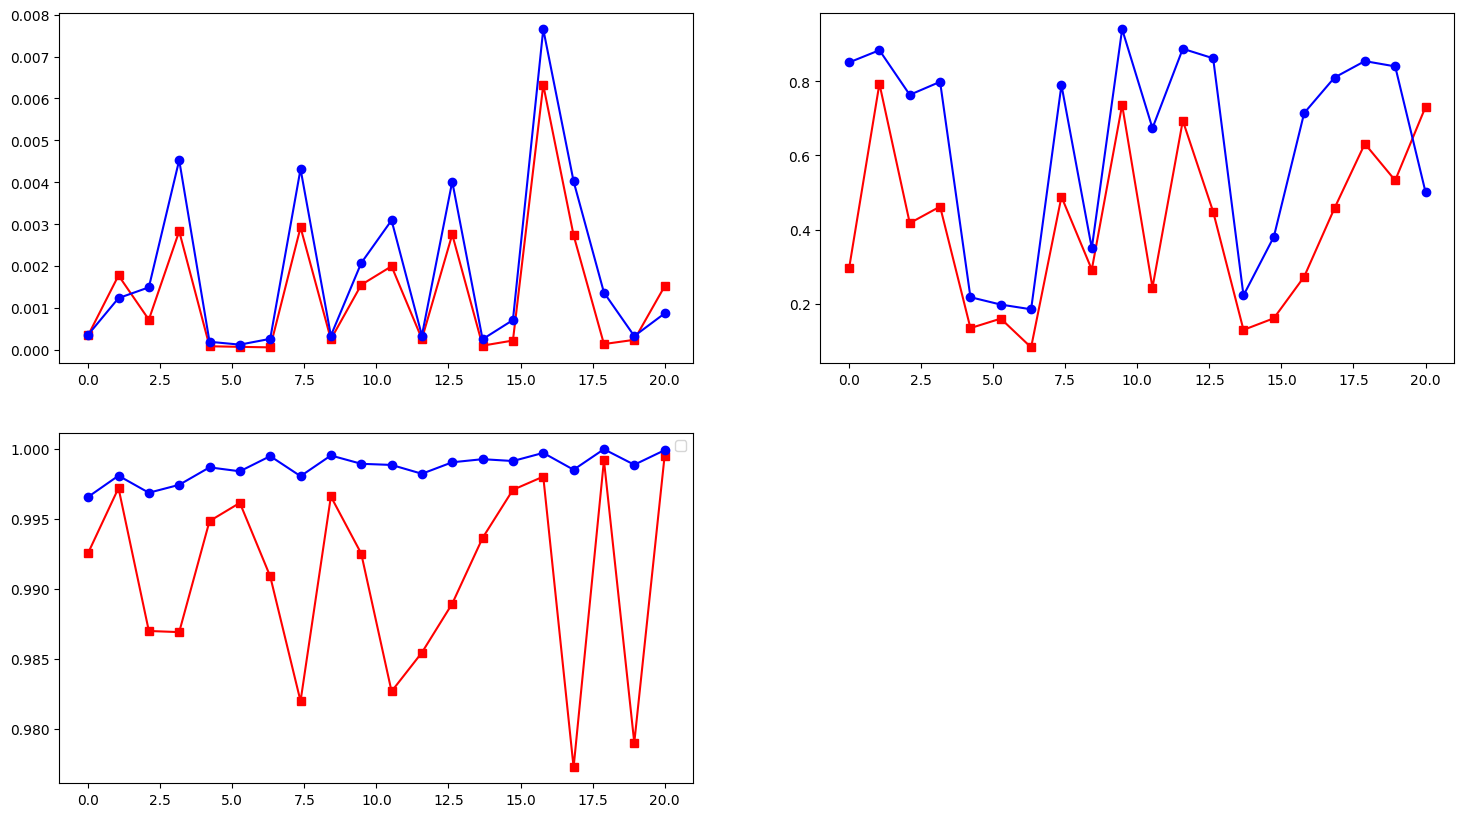

In [14]:
rse = []
rse_x= []
rse_xx = []


for i in range(20):
    subsampled_u,subsampled_x,random_rows = subsample_f(u,t,x,timesteps)
    # Sample data points and values
    X = np.array([list(a) for a in zip(subsampled_x,t)])

    Y = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_x = np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_xx = np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])

    for rbf_func in (cubic_rbf(),multiquadratic_rbf()):
        # Interpolate the surface
        new_X,new_Y = build_final_condition(X,Y,K_)

        x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(new_X,new_Y,rbf_func)

        numerical_2nd_derivative_interpolated = ps.FiniteDifference(axis=0,order = 7,d=2)._differentiate(interpolated_values,t = np.ravel(x1_grid))
        numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 7)._differentiate(interpolated_values,t = np.ravel(x1_grid))

        rse.append(calc_error_2d(interpolated_values.reshape(x1_grid.shape).T,u)[0])
        rse_x.append(calc_error_2d(interpolated_values_x.reshape(x1_grid.shape).T,u_x)[0])
        rse_xx.append(calc_error_2d(numerical_2nd_derivative_interpolated.reshape(x1_grid.shape).T,u_xx)[0])

time = np.linspace(0,20,20)



fig = plt.figure(figsize=[18,10])
ax = fig.add_subplot(221)
ax.plot(time, rse[0::2], c='r',marker='s')
ax.plot(time,rse[1::2],c='b',marker='o')


ax2 = fig.add_subplot(222)
ax2.plot(time,rse_x[0::2],c='r',marker='s')
ax2.plot(time,rse_x[1::2],c='b',marker='o')

ax3 = fig.add_subplot(223)
ax3.plot(time,rse_xx[0::2],c='r',marker='s')
ax3.plot(time,rse_xx[1::2],c='b',marker='o')

plt.legend()
plt.show()

In [15]:
rse = []
rse_x= []
rse_xx = []


for i in range(20):
    subsampled_u,subsampled_x,random_rows = subsample_f(u,t,x,timesteps)
    # Sample data points and values
    X = np.array([list(a) for a in zip(subsampled_x,t)])

    Y = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_x = np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
    Y_xx = np.ravel(u_xx[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])

    for rbf_func in (IRBFN1_2d,IRBFN2_2d):
        # Interpolate the surface
        new_X,new_Y = build_final_condition(X,Y,K_)

        x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(new_X,new_Y,multiquadratic_rbf(),grid_points=new_X)

        rse.append(calc_error_1d(interpolated_values,Y)[0])
        rse_x.append(calc_error_1d(interpolated_values_x,Y_x)[0])
        rse_xx.append(calc_error_1d(interpolated_values_xx,Y_xx)[0])

time = np.linspace(0,20,20)



fig = plt.figure(figsize=[18,10])
ax = fig.add_subplot(221)
ax.plot(time, rse[0::2], c='r',marker='s')
ax.plot(time,rse[1::2],c='b',marker='o')


ax2 = fig.add_subplot(222)
ax2.plot(time,rse_x[0::2],c='r',marker='s')
ax2.plot(time,rse_x[1::2],c='b',marker='o')

ax3 = fig.add_subplot(223)
ax3.plot(time,rse_xx[0::2],c='r',marker='s')
ax3.plot(time,rse_xx[1::2],c='b',marker='o')

plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (200,) (100,) 

In [39]:
def build_cross_library(Theta,degree=2):
    m = Theta.shape[1]
    for i in range(m):
        for j in range(i+1,m):
            Theta = np.hstack((Theta,(Theta[:,i]*Theta[:,j]).reshape(-1,1)))
    return Theta

In [54]:
# Interpolate the surface
x1_grid,x2_grid, interpolated_values,interpolated_values_x,interpolated_values_xx,_ = RBFN_2d(X, Y,cubic_rbf())

_,_, _,interpolated_values_t,_,_ = RBFN_2d(X[:,[1,0]], Y,cubic_rbf())

In [38]:
Theta = np.array([np.ravel(x1_grid),np.ravel(x1_grid)**2,interpolated_values,interpolated_values_x,interpolated_values_xx]).T

In [41]:
Crossed_Theta = build_cross_library(Theta)

In [56]:
optimizer = ps.STLSQ(threshold=1e-3, alpha=1e6).fit(Crossed_Theta,interpolated_values_t)

optimizer.coef_

array([[-0.07965839,  0.        ,  0.06391449,  0.        ,  0.        ,
         0.        ,  0.        ,  0.01640288,  0.00517221,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])